In [2]:
# Install required libraries (uncomment if needed)
# !pip install requests pandas matplotlib

import requests
import pandas as pd
import logging
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from requests.exceptions import RequestException
import json
import numpy as np

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('fuel_price_analysis.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

### 1. Data Extraction

We define a function to fetch data from the API with:
- Retry mechanism (3 attempts, 2-second delay)
- Error handling for network and JSON issues
- Logging of all operations
- Display of a sample JSON response

In [3]:
def fetch_fuel_price_data(url, max_retries=3, delay=2):
    """
    Fetch fuel price data from the API with retry mechanism and error handling.
    
    Args:
        url (str): API endpoint URL
        max_retries (int): Maximum number of retry attempts
        delay (int): Delay between retries in seconds
    
    Returns:
        dict: JSON response from API or None if failed
    """
    for attempt in range(max_retries):
        try:
            logger.info(f"Attempting to fetch data (Attempt {attempt + 1}/{max_retries})")
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            
            data = response.json()
            logger.info("Successfully fetched data")
            
            # Print sample of JSON response
            logger.info("Sample of JSON response:")
            logger.info(json.dumps(data[0], indent=2))
            
            return data
            
        except RequestException as e:
            logger.error(f"Request failed: {str(e)}")
            if attempt < max_retries - 1:
                logger.info(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                logger.error("Max retries reached. Failed to fetch data.")
                return None
        except ValueError as e:
            logger.error(f"JSON decoding failed: {str(e)}")
            return None

# Fetch data
API_URL = "https://api.data.gov.my/data-catalogue?id=fuelprice"
json_data = fetch_fuel_price_data(API_URL)

if json_data is None:
    logger.error("Failed to retrieve data. Stopping execution.")
    raise SystemExit("Data retrieval failed.")

2025-04-28 00:18:49,719 - INFO - Attempting to fetch data (Attempt 1/3)
2025-04-28 00:18:50,265 - INFO - Successfully fetched data
2025-04-28 00:18:50,266 - INFO - Sample of JSON response:
2025-04-28 00:18:50,267 - INFO - {
  "date": "2025-04-24",
  "ron95": 2.05,
  "ron97": 3.18,
  "diesel": 2.88,
  "series_type": "level",
  "diesel_eastmsia": 2.15
}


### 2. Data Transformation

We transform the JSON data into a Pandas DataFrame with:

- Renamed columns for clarity
- Date conversion to datetime
- New columns for price differences and rolling averages
- Sorted data by date

In [4]:
def transform_data(json_data):
    """
    Transform JSON data into a structured DataFrame with additional features.
    Combines rows with the same date, creating new columns for weekly changes.
    
    Args:
        json_data (list): List of dictionaries from API response
    
    Returns:
        pandas.DataFrame: Transformed DataFrame
    """
    try:
        logger.info("Starting data transformation")
        
        # Convert to DataFrame
        df = pd.DataFrame(json_data)
        
        # Split DataFrame by series_type
        df_level = df[df['series_type'] == 'level'].copy()
        df_change = df[df['series_type'] == 'change_weekly'].copy()
        
        # Rename columns for level data
        df_level = df_level.rename(columns={
            'ron95': 'RON95_price',
            'ron97': 'RON97_price',
            'diesel': 'Diesel_price',
            'diesel_eastmsia': 'Diesel_eastmsia_price',
            'date': 'Date'
        })
        
        # Rename columns for change_weekly data
        df_change = df_change.rename(columns={
            'ron95': 'RON95_weekly_change',
            'ron97': 'RON97_weekly_change',
            'diesel': 'Diesel_weekly_change',
            'diesel_eastmsia': 'Diesel_eastmsia_weekly_change',
            'date': 'Date'
        })
        
        # Convert date to datetime
        df_level['Date'] = pd.to_datetime(df_level['Date'])
        df_change['Date'] = pd.to_datetime(df_change['Date'])
        df_level['Diesel_price_difference'] = df_level['Diesel_price'] - df_level['Diesel_eastmsia_price']
        
        # Drop unnecessary columns
        df_level = df_level.drop(columns=['series_type'])

        # Merge DataFrames on Date
        df_merged = pd.merge(
            df_level,
            df_change[['Date', 'RON95_weekly_change', 'RON97_weekly_change', 
                      'Diesel_weekly_change', 'Diesel_eastmsia_weekly_change']],
            on='Date',
            how='left'
        )
        
        # Sort by date ascending
        df_merged = df_merged.sort_values('Date')
        
        # Calculate 4-week rolling averages
        df_merged['RON95_4wk_avg'] = df_merged['RON95_price'].rolling(window=4).mean()
        df_merged['RON97_4wk_avg'] = df_merged['RON97_price'].rolling(window=4).mean()
        df_merged['Diesel_4wk_avg'] = df_merged['Diesel_price'].rolling(window=4).mean()
        df_merged['Diesel_eastmsia_4wk_avg'] = df_merged['Diesel_eastmsia_price'].rolling(window=4).mean()
        
        logger.info("Data transformation completed successfully")
        return df_merged
        
    except Exception as e:
        logger.error(f"Data transformation failed: {str(e)}")
        return None

# Transform data
df = transform_data(json_data)
if df is None:
    logger.error("Data transformation failed. Stopping execution.")
    raise SystemExit("Data transformation failed.")

# Display first few rows
df.tail(10)

2025-04-28 00:18:50,278 - INFO - Starting data transformation
2025-04-28 00:18:50,293 - INFO - Data transformation completed successfully


,Date,RON95_price,RON97_price,Diesel_price,Diesel_eastmsia_price,Diesel_price_difference,RON95_weekly_change,RON97_weekly_change,Diesel_weekly_change,Diesel_eastmsia_weekly_change,RON95_4wk_avg,RON97_4wk_avg,Diesel_4wk_avg,Diesel_eastmsia_4wk_avg
9,2025-02-20,2.05,3.43,3.18,2.15,1.03,0.0,0.00,0.00,0.0,2.05,3.4300,3.1800,2.15
8,2025-02-27,2.05,3.43,3.18,2.15,1.03,0.0,0.00,0.00,0.0,2.05,3.4300,3.1800,2.15
7,2025-03-06,2.05,3.38,3.13,2.15,0.98,0.0,-0.05,-0.05,0.0,2.05,3.4175,3.1675,2.15
6,2025-03-13,2.05,3.28,3.06,2.15,0.91,0.0,-0.10,-0.07,0.0,2.05,3.3800,3.1375,2.15
5,2025-03-20,2.05,3.28,3.03,2.15,0.88,0.0,0.00,-0.03,0.0,2.05,3.3425,3.1000,2.15
4,2025-03-27,2.05,3.28,3.03,2.15,0.88,0.0,0.00,0.00,0.0,2.05,3.3050,3.0625,2.15
3,2025-04-03,2.05,3.33,3.03,2.15,0.88,0.0,0.05,0.00,0.0,2.05,3.2925,3.0375,2.15
2,2025-04-10,2.05,3.28,2.98,2.15,0.83,0.0,-0.05,-0.05,0.0,2.05,3.2925,3.0175,2.15
1,2025-04-17,2.05,3.18,2.88,2.15,0.73,0.0,-0.10,-0.10,0.0,2.05,3.2675,2.9800,2.15
0,2025-04-24,2.05,3.18,2.88,2.15,0.73,0.0,0.00,0.00,0.0,2.05,3.2425,2.9425,2.15


### 3. Insight Generation

We generate insights with:
- A time-series plot of fuel prices
- Identification of largest weekly price changes
- Summary statistics

2025-04-28 00:18:50,315 - INFO - Largest weekly price changes:
2025-04-28 00:18:50,316 - INFO - 
Top 5 largest price increases for RON95:
          Date  RON95_weekly_change
322 2019-02-23                 0.10
253 2020-06-27                 0.10
403 2017-04-13                 0.08
255 2020-06-13                 0.08
398 2017-05-18                 0.07

2025-04-28 00:18:50,317 - INFO - 
Top 5 largest price increases for RON97:
          Date  RON97_weekly_change
153 2022-05-26                 0.37
155 2022-05-12                 0.37
164 2022-03-10                 0.30
163 2022-03-17                 0.25
346 2018-06-07                 0.19

2025-04-28 00:18:50,317 - INFO - 
Top 5 largest price increases for Diesel:
          Date  Diesel_weekly_change
46  2024-06-10                  1.20
327 2019-01-19                  0.12
257 2020-05-30                  0.10
255 2020-06-13                  0.10
381 2017-09-14                  0.09

2025-04-28 00:18:50,318 - INFO - 
Top 5 largest price 

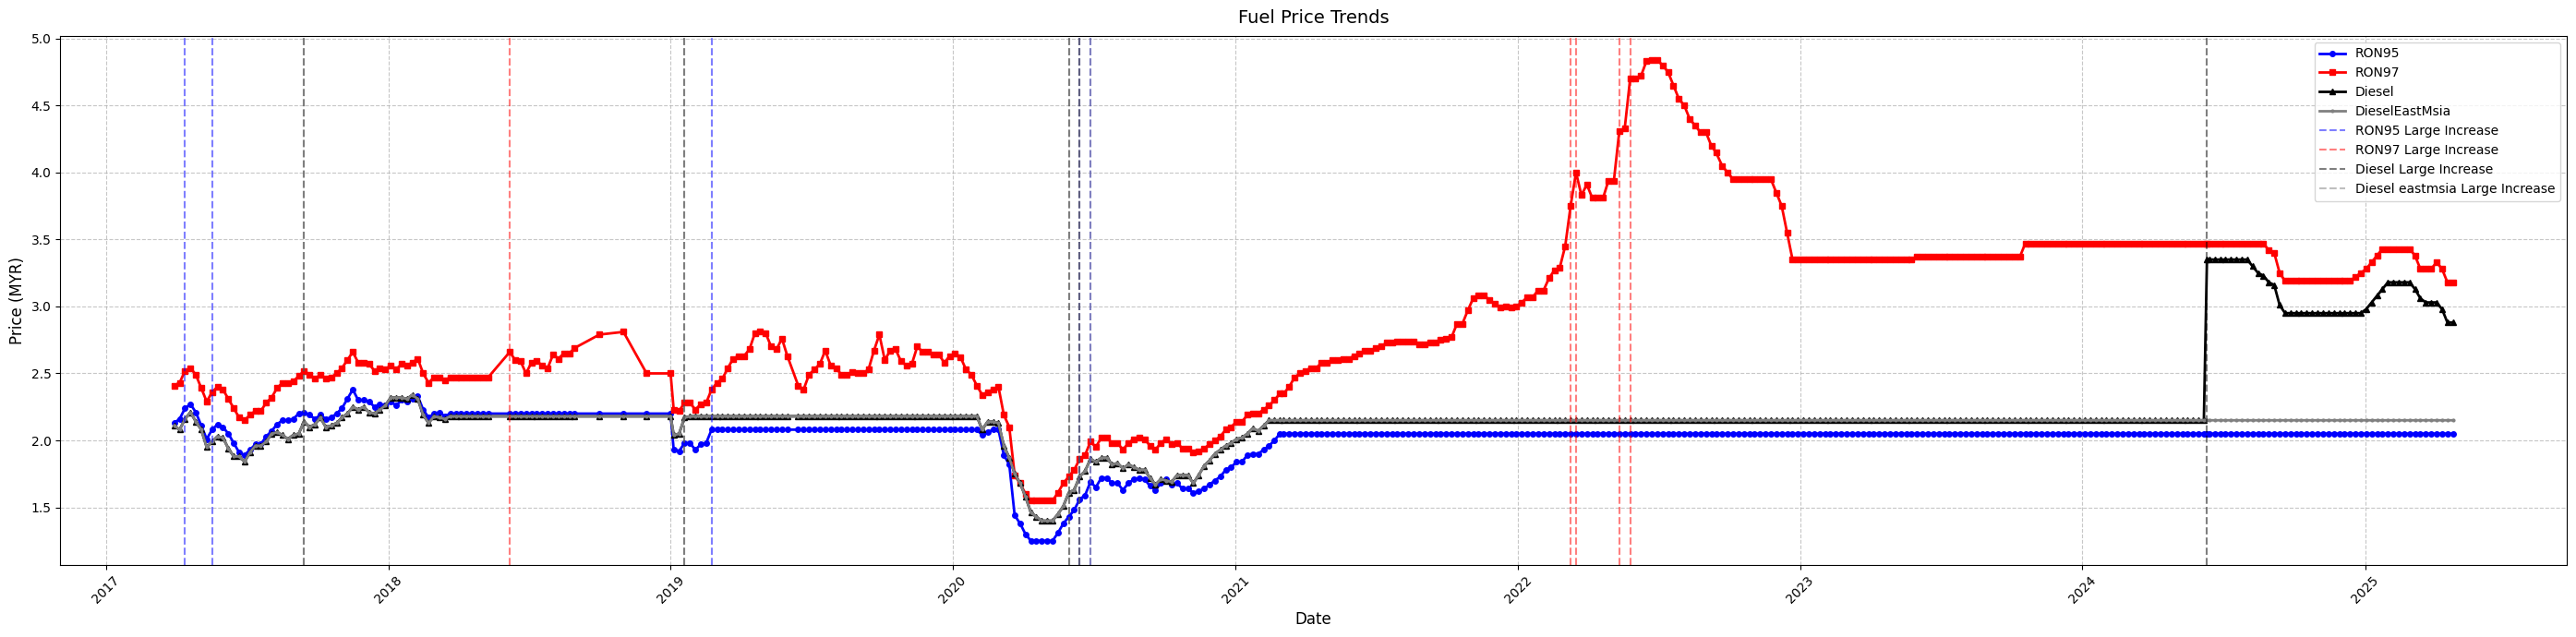

2025-04-28 00:18:50,450 - INFO - 
Summary Statistics (series_type = level):
       RON95_price  RON97_price  Diesel_price  Diesel_eastmsia_price
count   406.000000   406.000000    406.000000             406.000000
mean      2.024680     2.911847      2.214680               2.104778
std       0.175792     0.666286      0.357037               0.148712
min       1.250000     1.550000      1.400000               1.400000
25%       2.050000     2.470000      2.150000               2.150000
50%       2.050000     2.730000      2.150000               2.150000
75%       2.080000     3.370000      2.180000               2.150000
max       2.380000     4.840000      3.350000               2.340000


In [5]:
def generate_insights(df):
    """
    Generate insights and visualizations from transformed data.
    
    Args:
        df (pandas.DataFrame): Transformed DataFrame
    """
    try:            
        # Insight: Largest weekly price changes
        largest_changes = {
            'RON95': df[['Date', 'RON95_weekly_change']].nlargest(5, 'RON95_weekly_change'),
            'RON97': df[['Date', 'RON97_weekly_change']].nlargest(5, 'RON97_weekly_change'),
            'Diesel': df[['Date', 'Diesel_weekly_change']].nlargest(5, 'Diesel_weekly_change'),
            'Diesel eastmsia': df[['Date', 'Diesel_eastmsia_weekly_change']].nlargest(5, 'Diesel_eastmsia_weekly_change'),
        }
        
        logger.info("Largest weekly price changes:")
        for fuel_type, changes in largest_changes.items():
            # logger.info(f"\nTop 5 largest price increases for {fuel_type}:")
            logger.info(f"\nTop 5 largest price increases for {fuel_type}:\n{changes}\n")
        
        # Plot 1: Line graph for price trends over time (no shading, granular y-axis, highlighted dates)
        plt.figure(figsize=(28, 7))
        plt.plot(df['Date'], df['RON95_price'], label='RON95', linewidth=2, marker='o', markersize=4, color='blue')
        plt.plot(df['Date'], df['RON97_price'], label='RON97', linewidth=2, marker='s', markersize=4, color='red')
        plt.plot(df['Date'], df['Diesel_price'], label='Diesel', linewidth=2, marker='^', markersize=4, color='black')
        plt.plot(df['Date'], df['Diesel_eastmsia_price'], label='DieselEastMsia', linewidth=2, marker='.', markersize=4, color='grey')
        
        # Highlight dates of largest price changes
        for fuel_type, changes in largest_changes.items():
            color = {'RON95': 'blue', 'RON97': 'red', 'Diesel': 'black', 'Diesel eastmsia': 'grey'}[fuel_type]
            for date in changes['Date']:
                plt.axvline(x=date, color=color, linestyle='--', alpha=0.5, label=f'{fuel_type} Large Increase' if date == changes['Date'].iloc[0] else "")
        
        plt.title('Fuel Price Trends', fontsize=14, pad=10)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price (MYR)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        summary_stats = df[['RON95_price', 'RON97_price', 'Diesel_price', 'Diesel_eastmsia_price']].describe()
        logger.info(f"\nSummary Statistics (series_type = level):\n{summary_stats}")
        
    except Exception as e:
        logger.error(f"Insight generation failed: {str(e)}")

# Generate insights
generate_insights(df)